# Copernicus Climate Change Service (C3S) - Upper Air Data Service 

   This IPython Notebook is intended for demonstration purposes and example usage of the Homogenization software for Radiosonde humidity data.
   For further information please refer to the Deliverable Document or the script `raso_adj_cdm_v0.py` on [Github CEUAS](https://github.com/MBlaschek/CEUAS/tree/master/CEUAS/public/adjust).

 Table of Contents:
* [Downloading of data](#Downloading-of-data)
* [Investigating the data](#Investigating-the-data)
* [Running the Homogenization software](#Running-the-Homogenization-software)
* [Investigating results](#Investigating-results)

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Plotting parameters
plt.rcParams['figure.figsize'] = [12.0, 6.0]
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['font.size'] = 15
plt.style.use('seaborn-colorblind')
yplevs = np.array([10,30,70,125,175,225,300,400,500,700,925])
ylabels = list(map("{:.0f}".format,yplevs))
yplevs = list(yplevs*100)

In [3]:
#
# Make sure you have Python 3
#
from platform import python_version
if python_version()[0] != '3':
    print("Your Version:", python_version())
    raise RuntimeError("This Notebook requires Python 3")

# Downloading of data
For demonstration purposes, example data is allready available but we show here how to download these data from the CDS.

A typical request should contain:
1. **statid** - the Station Identifier
2. **date** - datetime selection YYYYMMDD
3. **pressure_level** - selection of pressure levels
4. **variable** - selection of variables 
5. **fbstats**  - feedback information from reanalysis

In [4]:
#
# Set to 'True' to enable download, example data is provided
#
if True:    
    import requests, zipfile, io, os, time
    t0 = time.time()
    #
    # This is for Python 3+
    #
    options = {"statid": "72357",
               "date": [19900101, 20181231],
               "variable": ["temperature", "relative_humidity"],
               "fbstats": ["obs_minus_bg", "obs_minus_an", "bias_estimate"]
               }
    #
    # Download significant levels
    #
    if False:
        #
        # Standard pressure levels only (faster retrieval)
        #
        options["pressure_level"] = [1000, 2000, 3000, 5000, 7000, 10000, 15000, 20000, 25000, 30000, 40000, 50000, 70000, 85000, 92500, 100000]
    #                            
    # http://early-upper-air.copernicus-climate.eu
    r = requests.post('http://srvx8.img.univie.ac.at:8004',
                      headers={'content-type': 'application/json'},
                      json=options,
                      stream=True)
    #
    # Check for known Error Message
    #
    if r.status_code != requests.codes.ok:
        print(r.text)
        raise RuntimeError("Something is not correct with the request")
    #
    # Create directory
    #
    if not os.path.isdir('./example_data'):
        os.makedirs('./example_data')
    #
    # Unzip the Data Stream
    #
    try:
        z = zipfile.ZipFile(io.BytesIO(r.content))
        print("Retreived files: ")
        print(z.namelist())
        z.extractall(path='./example_data')
    except:
        print(r.text)
        print("Error in request")    
    print("Time elapsed: ", time.time()-t0, "s")
else:
    print("Using the data in ./example_data")
    print(os.listdir('./example_data'))

Retreived files: 
['dest_72357_air_temperature.nc', 'dest_72357_relative_humidity.nc']
Time elapsed:  6.8637895584106445 s


Another Way can be use a Linux tool called `curl` to download a zipfile:
```bash
curl -H "Content-Type: application/json" -X POST --digest --data '{"statid":"72357","date":[19900101,20181231],"pressure_level":[1000, 2000, 3000, 5000, 7000, 10000, 15000, 20000, 25000, 30000, 40000, 50000, 70000, 85000, 92500, 100000],"variable":["temperature","relative_humidity"],"fbstats":["obs_minus_bg","obs_minus_an","bias_estimate"]}' -o example_data/download.zip http://early-upper-air.copernicus-climate.eu
```
and then unzip the contents in the directory
```bash
unzip -o example_data/download.zip
```

In [5]:
# Show the new downloaded files in example_data directory
!tree -Dhr example_data

example_data
├── [ 46M Jan 30  9:23]  dest_72357_relative_humidity_out.nc
├── [ 23M Jan 30 16:04]  dest_72357_relative_humidity.nc
└── [ 25M Jan 30 16:04]  dest_72357_air_temperature.nc

0 directories, 3 files


In [6]:
# Example output of retrieved NetCDF file
!ncdump -h example_data/dest_72357_air_temperature.nc

netcdf dest_72357_air_temperature {
dimensions:
	obs = 1346329 ;
	string5 = 5 ;
	trajectory = 21418 ;
variables:
	float bias_estimate(obs) ;
		bias_estimate:cdmname = "era5fb/biascorr@body" ;
		bias_estimate:units = "K" ;
		bias_estimate:coordinates = "lat lon time plev" ;
		bias_estimate:cdsname = "bias_estimate" ;
		bias_estimate:standard_name = "air_temperature" ;
		bias_estimate:long_name = "ERA5 reanalysis bias_estimate" ;
	float lat(obs) ;
		lat:cdmname = "observations_table/latitude" ;
		lat:units = "degree_north" ;
		lat:standard_name = "latitude" ;
	float lon(obs) ;
		lon:cdmname = "observations_table/longitude" ;
		lon:units = "degree_east" ;
		lon:standard_name = "longitude" ;
	float obs_minus_an(obs) ;
		obs_minus_an:cdmname = "era5fb/an_depar@body" ;
		obs_minus_an:units = "K" ;
		obs_minus_an:coordinates = "lat lon time plev" ;
		obs_minus_an:cdsname = "obs_minus_an" ;
		obs_minus_an:standard_name = "air_temperature" ;
		obs_minus_an:long_name = "ERA5 reanalysis obs_minus

# Investigating the data

At the moment (01.2020), the database is at version 0, however, the data files seen here will be very similar to the ones delivered by the end of the contract.

The following shows how to open these files and read information. These are very common routines for data analysis. NetCDF can be read by numerous packages in Python. Xarray proves to be the most useful at the moment.


In [7]:
import xarray as xr

In [8]:
ident = '72357'  # Station Identifier

In [9]:
tdata = xr.load_dataset('example_data/dest_{}_air_temperature.nc'.format(ident))

In [10]:
rdata = xr.load_dataset('example_data/dest_{}_relative_humidity.nc'.format(ident))

## Temperature data in Xarray

Notice that there are the following variables:
* bias_estimate - Reanalysis Bias estimate
* obs_min_an - Analysis Departures
* obs_min_bg - First Guess Departures
* ta - Temperature observations

In [11]:
tdata

<xarray.Dataset>
Dimensions:           (obs: 1346329, trajectory: 21418)
Coordinates:
    lat               (obs) float32 35.23 35.23 35.23 ... 35.18083 35.18083
    lon               (obs) float32 -97.47 -97.47 -97.47 ... -97.43778 -97.43778
    plev              (obs) float32 980.0 1000.0 1120.0 ... 92500.0 100000.0
    time              (obs) datetime64[ns] 1990-01-01 ... 2018-12-31T23:04:00
Dimensions without coordinates: obs, trajectory
Data variables:
    bias_estimate     (obs) float32 -1.340332 -1.340332 nan ... -0.02625 nan
    obs_minus_an      (obs) float32 -0.173956 0.280334 nan ... 1.084904 nan
    obs_minus_bg      (obs) float32 -0.039262 0.427206 nan ... 1.18198 nan
    ta                (obs) float32 218.9 219.3 nan nan ... 273.35 279.75 nan
    trajectory_index  (obs) int32 0 0 0 0 0 0 ... 21417 21417 21417 21417 21417
    trajectory_label  (trajectory) |S5 b'00551' b'00552' ... b'23679' b'23680'
Attributes:
    primary_id:    0-20000-0-72357
    station_name:  NORMAN/

## Relative humidity 

In [12]:
rdata

<xarray.Dataset>
Dimensions:           (obs: 1346329, trajectory: 21418)
Coordinates:
    lat               (obs) float32 35.23 35.23 35.23 ... 35.18083 35.18083
    lon               (obs) float32 -97.47 -97.47 -97.47 ... -97.43778 -97.43778
    plev              (obs) float32 980.0 1000.0 1120.0 ... 92500.0 100000.0
    time              (obs) datetime64[ns] 1990-01-01 ... 2018-12-31T23:04:00
Dimensions without coordinates: obs, trajectory
Data variables:
    bias_estimate     (obs) float32 nan nan nan nan nan ... nan nan nan nan nan
    hur               (obs) float32 nan nan nan nan ... 0.838794 0.654979 nan
    obs_minus_an      (obs) float32 nan nan nan nan ... -0.054035 -0.091665 nan
    obs_minus_bg      (obs) float32 nan nan nan nan ... -0.050184 -0.050518 nan
    trajectory_index  (obs) int32 0 0 0 0 0 0 ... 21417 21417 21417 21417 21417
    trajectory_label  (trajectory) |S5 b'00551' b'00552' ... b'23679' b'23680'
Attributes:
    primary_id:    0-20000-0-72357
    station_na

In [13]:
# Relative Humidity variable
rdata.hur

<xarray.DataArray 'hur' (obs: 1346329)>
array([     nan,      nan,      nan, ..., 0.838794, 0.654979,      nan],
      dtype=float32)
Coordinates:
    lat      (obs) float32 35.23 35.23 35.23 ... 35.18083 35.18083 35.18083
    lon      (obs) float32 -97.47 -97.47 -97.47 ... -97.43778 -97.43778
    plev     (obs) float32 980.0 1000.0 1120.0 ... 85000.0 92500.0 100000.0
    time     (obs) datetime64[ns] 1990-01-01 1990-01-01 ... 2018-12-31T23:04:00
Dimensions without coordinates: obs
Attributes:
    cdmname:        observations_table/observation_value
    units:          1
    standard_name:  relative_humidity
    cdsname:        relative_humidity

## Plotting

/raid8/srvx1/mblaschek/.conda/envs/bunnies/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Radiosonde Temperature Observations from 72357 at 500 hPa')

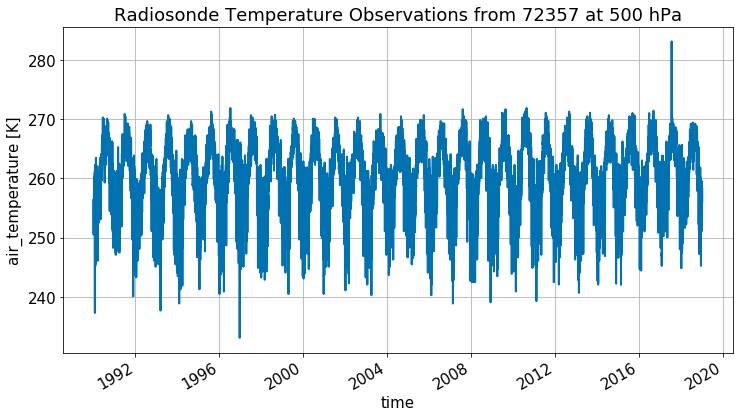

In [14]:
# Selecting only data for 500 hPa
# notice that the dimension is not time yet, but obs
tdata.ta.sel(obs=(tdata.plev==50000)).swap_dims({'obs':'time'}).plot()
grid()
title("Radiosonde Temperature Observations from {} at 500 hPa".format(ident))

Text(0.5, 1.0, 'Radiosonde relative humidity Observations from 72357 at 500 hPa')

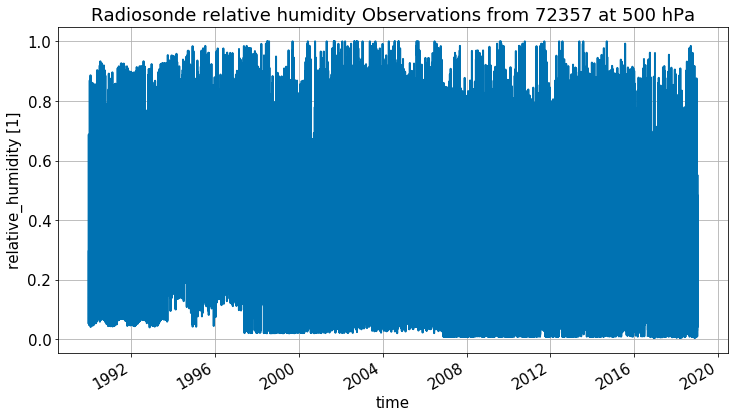

In [15]:
rdata.hur.sel(obs=(rdata.plev==50000)).swap_dims({'obs':'time'}).plot()
grid()
title("Radiosonde relative humidity Observations from {} at 500 hPa".format(ident))

# Running the Homogenization Software

The following steps are completed automatically within this script:
1. Read data (`ifile`)
2. Look for required variables
    - Need observations and obs_minus_an
3. Select only standard times (`0, 12`)
4. Convert to `hour x time x pressure` cubes
5. Calculate test statistics
6. Detect Breakpoints
7. Calculate Adjustments
8. Return/Write data

The Python script can also be run from the command line:
```bash
>>> python raso_adj_cdm_v0.py -h

Run standardized radiosonde homogenisation software on CDM compliant file

raso_adj_cdm_v0.py -h -f [file] -o [name] 

Options:
    -h              Help
    --help      
    -f []           Input CDM compliant file
    --file []       
    -o []           Output name
    --output []
    
Optional Keyword Options:
    --thres []      Threshold value for SNHT, default: 50

```

It is also possible to import the script like a module and execute some functions individually or the `main`.

**Notice: This script has been tested with some parameters, but not every combination has been tested. It is recommended for unexperienced users to use the default options and begin testing from there.**

## Import script as Module

Intended for Notebook use

In [16]:
import raso_adj_cdm_v0

### Usage information

In [17]:
raso_adj_cdm_v0.usage()


Run standardized radiosonde homogenisation software on CDM compliant file

raso_adj_cdm_v0.py -h -f [file] -o [name] 

Options:
    -h              Help
    --help      
    -f []           Input CDM compliant file
    --file []       
    -o []           Output name
    --output []
    
Optional Keyword Options:
    --thres []          Threshold value for SNHT, default: 50
    --window []         Moving Window for SNHT, default: 1470 (in days, 4 years)
    --missing []        Maximum allowed missing values in window, default: 600 (in days)
    --min_levels []     Minimum required levels for significant breakpoint, default: 3
    --dist []           Minimum distance between breakpoints, default: 730 (in days, 2 years)
    --sample_size []    Minimum sample size for statistics, default: 130 (in days)
    --borders []        Breakpoint zone, default: 90 (in days)
    --ratio []          Use ratio instead of differences, default: 0 (not)

    --logfile []        Write messages to a log f

### Execute Main

the `main` function 

    call signature:
    raso_adj_cdm_v0.main(ifile=None, ofile=None, **kwargs)

needs to be called with a `ifile` string, that is a path to one file or multiple files from one radiosonde. Either specify an output filename or a modified inputfile name will be used.

As described in the `usage` it requires inputdata and Keyword-Options. To return the data directly to the Notebook give the `donotwrite=True` Argument, as seen below.

In [18]:
raso_adj_cdm_v0.main(ifile="example_data/*[!_out].nc", adddate=True)

[2020-01-30T16:04:09.814154] [INFO] Multiple input files:  example_data/*[!_out].nc  | # 2
[2020-01-30T16:04:10.072237] [INPUT] example_data/dest_72357_air_temperature.nc ta
[2020-01-30T16:04:10.289810] [INPUT] example_data/dest_72357_relative_humidity.nc hur
[2020-01-30T16:04:10.337049] [CONVERT] Converting to DataCube ...
[2020-01-30T16:04:10.339656] [BKP] Observations obs: 1346329
[2020-01-30T16:04:10.339733] [BKP] Trajectories obs: 1346329,trajectory: 21418
[2020-01-30T16:04:10.407868] [TIME] Dates: 1990-01-01 00:00:00  -  2018-12-31 23:04:00 Duplicates: 1324911
[2020-01-30T16:04:10.445479] [CONVERT] Selecting only standard pressure levels
[2020-01-30T16:04:13.073172] [CONVERT] Done
[2020-01-30T16:04:13.354369] [CONVERT] Standard time calculated, Duplicates resolved: 53
[2020-01-30T16:04:13.467751] [CONVERT] Converting to day-night Array [hour x time x pressure]
[2020-01-30T16:04:13.467863] [CHECK] Departures found ta obs_minus_an
[2020-01-30T16:04:13.467901] [CHECK] Departures fou

/raid8/srvx1/mblaschek/workspace/pybench/development/CEUAS/CEUAS/public/adjust/raso_adj_cdm_v0.py:632: RuntimeWarning: Mean of empty slice
  before = np.nanmean(data[isample], axis=axis)
/raid8/srvx1/mblaschek/.conda/envs/bunnies/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1371: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input, interpolation=interpolation


[2020-01-30T16:04:15.885512] Breakpoints for  hur_obs_minus_an_snht_breaks
[2020-01-30T16:04:15.885600] [     idx] [     end] [    peak] [   start] [ #]
[2020-01-30T16:04:15.885637] [    3067] 1996-10-10 1998-05-31 1999-10-20 1104
[2020-01-30T16:04:15.885665] [    6125] 2005-06-07 2006-10-31 2007-12-25  903
[2020-01-30T16:04:15.885690] [    8653] 2012-09-07 2013-10-23 2015-03-28  924
[2020-01-30T16:04:15.885720] [ADJUST] Breakpoints:  3
[2020-01-30T16:04:15.886361] [ADJUST] Sample size: 10 N-Q: 13
[2020-01-30T16:04:15.916736] [ALIGN] hour x time -> datetime 
[2020-01-30T16:04:15.977655] [REVERSE] Selecting variables
[2020-01-30T16:04:15.977972] [REVERSE] time to obs
[2020-01-30T16:04:16.341136] [TRAJ] Add trajectory information
[2020-01-30T16:04:16.372905] [OUT] Writing ...
[2020-01-30T16:04:16.373393] [OUTPUT] example_data/dest_72357_relative_humidity_out.nc bias_estimate, obs_minus_an, obs_minus_bg, hur_q, obs_minus_an_snht, obs_minus_an_snht_breaks, trajectory_index, trajectory_labe

In [19]:
!ls -lh example_data/

insgesamt 95M
-rw-r--r--. 1 mblaschek users 26M 30. Jän 16:04 dest_72357_air_temperature.nc
-rw-r--r--. 1 mblaschek users 24M 30. Jän 16:04 dest_72357_relative_humidity.nc
-rw-r--r--. 1 mblaschek users 46M 30. Jän 16:04 dest_72357_relative_humidity_out.nc


In [20]:
!ncdump -h example_data/dest_72357_relative_humidity_out.nc

netcdf dest_72357_relative_humidity_out {
dimensions:
	obs = 1346329 ;
	trajectory = 21418 ;
	string5 = 5 ;
variables:
	float bias_estimate(obs) ;
		bias_estimate:_FillValue = NaNf ;
		bias_estimate:cdmname = "era5fb/biascorr@body" ;
		bias_estimate:units = "1" ;
		bias_estimate:cdsname = "bias_estimate" ;
		bias_estimate:standard_name = "relative_humidity" ;
		bias_estimate:long_name = "ERA5 reanalysis bias_estimate" ;
		bias_estimate:coordinates = "plev lon lat time" ;
	float obs_minus_an(obs) ;
		obs_minus_an:_FillValue = NaNf ;
		obs_minus_an:cdmname = "era5fb/an_depar@body" ;
		obs_minus_an:units = "1" ;
		obs_minus_an:cdsname = "obs_minus_an" ;
		obs_minus_an:standard_name = "relative_humidity" ;
		obs_minus_an:long_name = "ERA5 reanalysis obs_minus_an" ;
		obs_minus_an:coordinates = "plev lon lat time" ;
	float obs_minus_bg(obs) ;
		obs_minus_bg:_FillValue = NaNf ;
		obs_minus_bg:cdmname = "era5fb/fg_depar@body" ;
		obs_minus_bg:units = "1" ;
		obs_minus_bg:cdsname = "obs_minus_

### Execute and return CDM data

give the option `donotwrite=True` to the module and the data will be return to the Notebook

In [21]:
data = raso_adj_cdm_v0.main(ifile="example_data/*[!_out].nc", donotwrite=True, adddate=True)

[2020-01-30T16:04:38.304895] [INFO] Multiple input files:  example_data/*[!_out].nc  | # 2
[2020-01-30T16:04:38.589648] [INPUT] example_data/dest_72357_air_temperature.nc ta
[2020-01-30T16:04:38.823006] [INPUT] example_data/dest_72357_relative_humidity.nc hur
[2020-01-30T16:04:38.876178] [CONVERT] Converting to DataCube ...
[2020-01-30T16:04:38.879338] [BKP] Observations obs: 1346329
[2020-01-30T16:04:38.879408] [BKP] Trajectories obs: 1346329,trajectory: 21418
[2020-01-30T16:04:38.940373] [TIME] Dates: 1990-01-01 00:00:00  -  2018-12-31 23:04:00 Duplicates: 1324911
[2020-01-30T16:04:38.970069] [CONVERT] Selecting only standard pressure levels
[2020-01-30T16:04:41.373560] [CONVERT] Done
[2020-01-30T16:04:41.653703] [CONVERT] Standard time calculated, Duplicates resolved: 53
[2020-01-30T16:04:41.741707] [CONVERT] Converting to day-night Array [hour x time x pressure]
[2020-01-30T16:04:41.741819] [CHECK] Departures found ta obs_minus_an
[2020-01-30T16:04:41.741859] [CHECK] Departures fou

/raid8/srvx1/mblaschek/workspace/pybench/development/CEUAS/CEUAS/public/adjust/raso_adj_cdm_v0.py:632: RuntimeWarning: Mean of empty slice
  before = np.nanmean(data[isample], axis=axis)
/raid8/srvx1/mblaschek/.conda/envs/bunnies/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1371: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input, interpolation=interpolation


[2020-01-30T16:04:42.078628] [ALIGN] hour x time -> datetime 
[2020-01-30T16:04:42.148237] [REVERSE] Selecting variables
[2020-01-30T16:04:42.148359] [REVERSE] time to obs
[2020-01-30T16:04:42.490978] [TRAJ] Add trajectory information
[2020-01-30T16:04:42.521170] [OUT] Returning data


In [22]:
data

<xarray.Dataset>
Dimensions:                       (obs: 1346329, trajectory: 21418)
Coordinates:
    lat                           (obs) float32 35.23 35.23 ... 35.18083
    lon                           (obs) float32 -97.47 -97.47 ... -97.43778
    plev                          (obs) float64 980.0 1e+03 ... 9.25e+04 1e+05
    time                          (obs) datetime64[ns] 1990-01-01 ... 2018-12-31T23:04:00
Dimensions without coordinates: obs, trajectory
Data variables:
    ta_bias_estimate              (obs) float32 -1.340332 -1.340332 ... nan
    ta_obs_minus_an               (obs) float32 -0.173956 0.280334 ... nan
    ta_obs_minus_bg               (obs) float32 -0.039262 0.427206 ... nan
    ta                            (obs) float32 218.9 219.3 nan ... 279.75 nan
    hur_bias_estimate             (obs) float32 nan nan nan nan ... nan nan nan
    hur                           (obs) float32 nan nan nan ... 0.654979 nan
    hur_obs_minus_an              (obs) float32 nan nan na

### Execute and interpolate to non-standard times and levels

Give the option `interpolate_missing=True` to the module and the adjustments will be interpolated to non-standard times and non-standard pressure levels

**Notice: Takes a bit longer to run (+1:40 minutes)**

In a revised version, the performance of the interpolation of individual profiles can be improved.

In [24]:
data = raso_adj_cdm_v0.main(ifile="example_data/*[!_out].nc", donotwrite=True, adddate=True, interpolate_missing=True)

[2020-01-30T16:06:13.623413] [INFO] Multiple input files:  example_data/*[!_out].nc  | # 2
[2020-01-30T16:06:13.849063] [INPUT] example_data/dest_72357_air_temperature.nc ta
[2020-01-30T16:06:14.074577] [INPUT] example_data/dest_72357_relative_humidity.nc hur
[2020-01-30T16:06:14.121784] [CONVERT] Converting to DataCube ...
[2020-01-30T16:06:14.124377] [BKP] Observations obs: 1346329
[2020-01-30T16:06:14.124480] [BKP] Trajectories obs: 1346329,trajectory: 21418
[2020-01-30T16:06:14.183155] [TIME] Dates: 1990-01-01 00:00:00  -  2018-12-31 23:04:00 Duplicates: 1324911
[2020-01-30T16:06:14.210686] [CONVERT] Selecting only standard pressure levels
[2020-01-30T16:06:16.347514] [CONVERT] Done
[2020-01-30T16:06:16.632319] [CONVERT] Standard time calculated, Duplicates resolved: 53
[2020-01-30T16:06:16.719412] [CONVERT] Converting to day-night Array [hour x time x pressure]
[2020-01-30T16:06:16.719759] [CHECK] Departures found ta obs_minus_an
[2020-01-30T16:06:16.719801] [CHECK] Departures fou

/raid8/srvx1/mblaschek/workspace/pybench/development/CEUAS/CEUAS/public/adjust/raso_adj_cdm_v0.py:632: RuntimeWarning: Mean of empty slice
  before = np.nanmean(data[isample], axis=axis)
/raid8/srvx1/mblaschek/.conda/envs/bunnies/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1371: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input, interpolation=interpolation


[2020-01-30T16:06:17.061325] [ALIGN] hour x time -> datetime 
[2020-01-30T16:06:17.116524] [REVERSE] Selecting variables
[2020-01-30T16:06:17.116646] [REVERSE] time to obs
[2020-01-30T16:06:17.449161] [INTERP] Interpolating non-standard times  hur_q
[2020-01-30T16:06:18.211063] [INTERP] Interpolating non-standard pressure  hur_q
[2020-01-30T16:07:53.624165] [INTERP] Interpolation complete
[2020-01-30T16:07:53.624520] [TRAJ] Add trajectory information
[2020-01-30T16:07:53.646117] [OUT] Returning data


In [25]:
data

<xarray.Dataset>
Dimensions:                       (obs: 1346329, trajectory: 21418)
Coordinates:
    lat                           (obs) float32 35.23 35.23 ... 35.18083
    lon                           (obs) float32 -97.47 -97.47 ... -97.43778
    plev                          (obs) float64 980.0 1e+03 ... 9.25e+04 1e+05
    time                          (obs) datetime64[ns] 1990-01-01 ... 2018-12-31T23:04:00
Dimensions without coordinates: obs, trajectory
Data variables:
    ta_bias_estimate              (obs) float32 -1.340332 -1.340332 ... nan
    ta_obs_minus_an               (obs) float32 -0.173956 0.280334 ... nan
    ta_obs_minus_bg               (obs) float32 -0.039262 0.427206 ... nan
    ta                            (obs) float32 218.9 219.3 nan ... 279.75 nan
    hur_bias_estimate             (obs) float32 nan nan nan nan ... nan nan nan
    hur                           (obs) float32 nan nan nan ... 0.654979 nan
    hur_obs_minus_an              (obs) float32 nan nan na

### Check for interpolated adjustments

In [26]:
# Count the amount of levels per profile
isel = data['hur'].groupby('time').count()

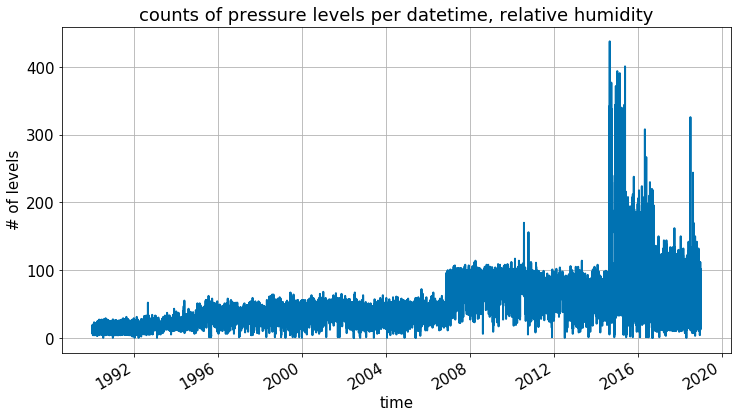

In [27]:
isel.plot()
grid()
ylabel('# of levels')
title('counts of pressure levels per datetime, relative humidity');

In [28]:
# Select a profile where adjustments have been calculated
ilogic = (isel.time.to_index() < '1998') & (isel > 50)
print(isel[ilogic])

<xarray.DataArray 'hur' (time: 51)>
array([52, 55, 51, 51, 55, 56, 54, 56, 52, 52, 51, 59, 62, 52, 54, 51, 58,
       57, 53, 51, 51, 53, 54, 51, 51, 51, 58, 55, 56, 54, 53, 52, 51, 51,
       51, 52, 52, 51, 52, 53, 51, 54, 52, 59, 53, 54, 52, 51, 54, 51, 52])
Coordinates:
  * time     (time) datetime64[ns] 1992-08-26T12:00:00 ... 1997-12-23T12:00:00


In [29]:
iobs = (data.time==isel.time[ilogic][-1])

### Plot Profile with interpolated adjustments

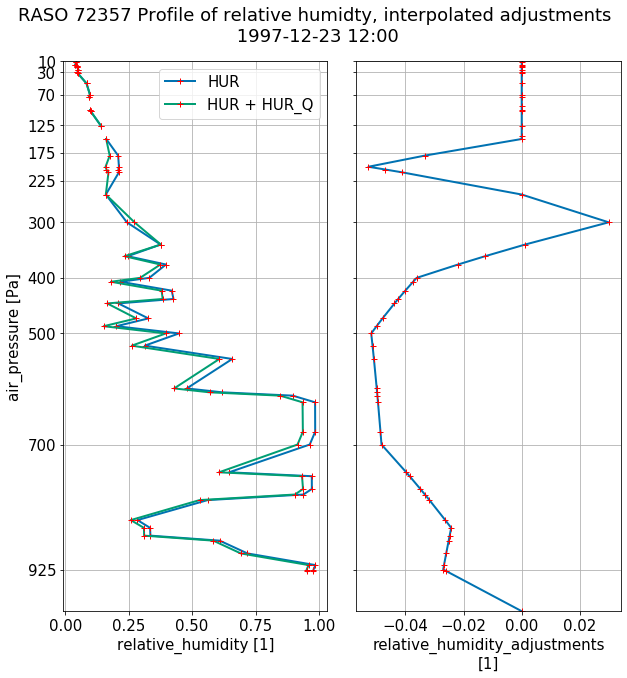

In [30]:
f,ax = subplots(1,2, sharey=True, figsize=(9,9))
data.sel(obs=iobs).hur.plot(y='plev', ax=ax[0], marker='+', mec='red' )
itmp = data.sel(obs=iobs)
(itmp.hur + itmp.hur_q).plot(y='plev', ax=ax[0], marker='+', mec='red' )
data.sel(obs=iobs).hur_q.plot(y='plev', ax=ax[1], marker='+', mec='red')
ax[0].set_yticks(ticks=yplevs)
ax[0].set_yticklabels(ylabels)
ylim(100000,1000)
ax[0].grid()
ax[1].grid()
ax[1].set_ylabel('')
ax[0].set_xlabel('relative_humidity [1]')
ax[0].legend(['HUR', 'HUR + HUR_Q'])
f.suptitle("RASO {} Profile of relative humidty, interpolated adjustments\n {}".format(ident, isel.time[ilogic].dt.strftime("%Y-%m-%d %H:%M").item(-1)), y=1.05);
tight_layout()

### Execute and return Data-Cube

Give the option `return_cube=True` to the module and the actual data (standard sounding times `(0,12)` and standard pressure levels), that is used to calculate the adjustments is return and can be studied.

In the following section this kind of representation will be used to illustrate the results.

In [31]:
data = raso_adj_cdm_v0.main(ifile="example_data/*[!_out].nc", return_cube=True, adddate=True)

[2020-01-30T16:07:57.531395] [INFO] Multiple input files:  example_data/*[!_out].nc  | # 2
[2020-01-30T16:07:57.773799] [INPUT] example_data/dest_72357_air_temperature.nc ta
[2020-01-30T16:07:58.006083] [INPUT] example_data/dest_72357_relative_humidity.nc hur
[2020-01-30T16:07:58.056352] [CONVERT] Converting to DataCube ...
[2020-01-30T16:07:58.058993] [BKP] Observations obs: 1346329
[2020-01-30T16:07:58.059078] [BKP] Trajectories obs: 1346329,trajectory: 21418
[2020-01-30T16:07:58.119682] [TIME] Dates: 1990-01-01 00:00:00  -  2018-12-31 23:04:00 Duplicates: 1324911
[2020-01-30T16:07:58.147919] [CONVERT] Selecting only standard pressure levels
[2020-01-30T16:08:00.520975] [CONVERT] Done
[2020-01-30T16:08:00.807345] [CONVERT] Standard time calculated, Duplicates resolved: 53
[2020-01-30T16:08:00.900021] [CONVERT] Converting to day-night Array [hour x time x pressure]
[2020-01-30T16:08:00.900142] [CHECK] Departures found ta obs_minus_an
[2020-01-30T16:08:00.900180] [CHECK] Departures fou

/raid8/srvx1/mblaschek/workspace/pybench/development/CEUAS/CEUAS/public/adjust/raso_adj_cdm_v0.py:632: RuntimeWarning: Mean of empty slice
  before = np.nanmean(data[isample], axis=axis)
/raid8/srvx1/mblaschek/.conda/envs/bunnies/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1371: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input, interpolation=interpolation


In [32]:
data

<xarray.Dataset>
Dimensions:                       (hour: 2, plev: 16, time: 10535)
Coordinates:
  * hour                          (hour) int64 0 12
  * plev                          (plev) float64 1e+03 2e+03 ... 9.25e+04 1e+05
  * time                          (time) datetime64[ns] 1990-01-01 ... 2019-01-01
Data variables:
    ta_bias_estimate              (hour, time, plev) float32 -1.340332 ... nan
    lat                           (hour, time, plev) float32 35.23 35.23 ... nan
    lon                           (hour, time, plev) float32 -97.47 ... nan
    ta_obs_minus_an               (hour, time, plev) float32 0.280334 ... nan
    ta_obs_minus_bg               (hour, time, plev) float32 0.427206 ... nan
    ta                            (hour, time, plev) float32 219.3 214.3 ... nan
    hur_bias_estimate             (hour, time, plev) float32 nan nan ... nan nan
    hur                           (hour, time, plev) float32 nan nan ... nan nan
    hur_obs_minus_an              (hou

# Investigating results

The homogenization results can be interpreted by looking at the following:

* [Analysis departures](#Departures)
* [Test and Breakpoints](#SNHT-&-Breakpoints)
* [Adjustments](#Adjustments)

In [33]:
# simple plotting function for xarrays
def easy_plot(data, **kwargs):
    dims = list(data.dims)
    return contourf(data[dims[1]].values, data[dims[0]].values, data.values, **kwargs)

In [34]:
ident = '72357'  # Station Identifier

## Departures

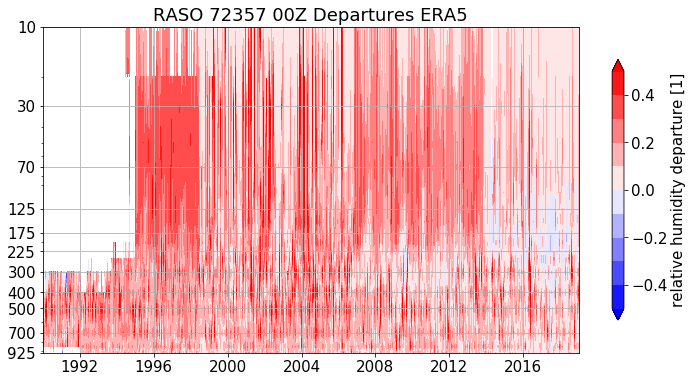

In [35]:
cs = easy_plot(data['hur_obs_minus_an'].sel(hour=0).T, levels=np.arange(-0.5,0.6,0.1),extend='both', cmap='bwr')
grid()
colorbar(cs, label='relative humidity departure [1]', shrink=0.8);
yscale('log')
ylim(100000, 1000)
yticks(ticks=yplevs, labels=ylabels);
title("RASO {} 00Z Departures ERA5".format(ident));

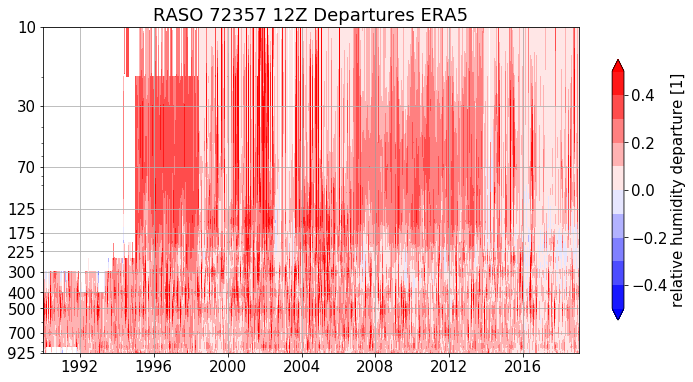

In [36]:
cs = easy_plot(data['hur_obs_minus_an'].sel(hour=12).T, levels=np.arange(-0.5,0.6,0.1),extend='both', cmap='bwr')
grid()
colorbar(cs, label='relative humidity departure [1]', shrink=0.8);
yscale('log')
ylim(100000, 1000)
yticks(ticks=yplevs, labels=ylabels);
title("RASO {} 12Z Departures ERA5".format(ident));

## SNHT & Breakpoints

Breakpoints: ['1998-05-31T00:00:00.000000000' '2006-11-13T00:00:00.000000000'
 '2013-10-24T00:00:00.000000000']


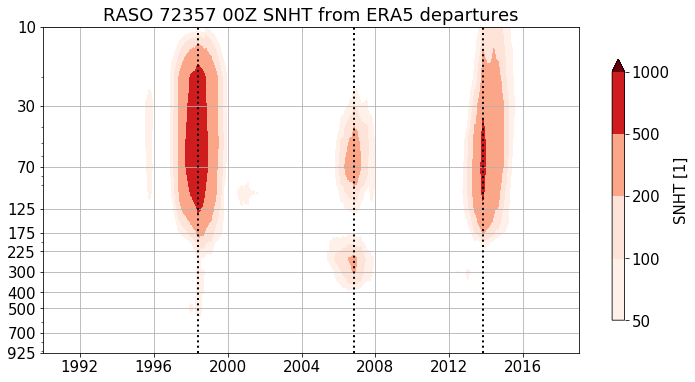

In [37]:
cs = easy_plot(data['hur_obs_minus_an_snht'].sel(hour=0).T, levels=[50,100,200,500,1000], cmap='Reds', extend='max')
ibreaks = raso_adj_cdm_v0.get_breakpoints(data['hur_obs_minus_an_snht_breaks'].sel(hour=0))
for i in ibreaks:
    axvline(x=data['time'].values[i], color='k', ls=':')
print("Breakpoints:", data['time'].values[ibreaks])
grid()
colorbar(cs, label='SNHT [1]', shrink=0.8);
yscale('log')
ylim(100000, 1000)
yticks(ticks=yplevs, labels=ylabels);
title("RASO {} 00Z SNHT from ERA5 departures".format(ident));

Breakpoints: ['1998-05-31T00:00:00.000000000' '2006-10-31T00:00:00.000000000'
 '2013-10-23T00:00:00.000000000']


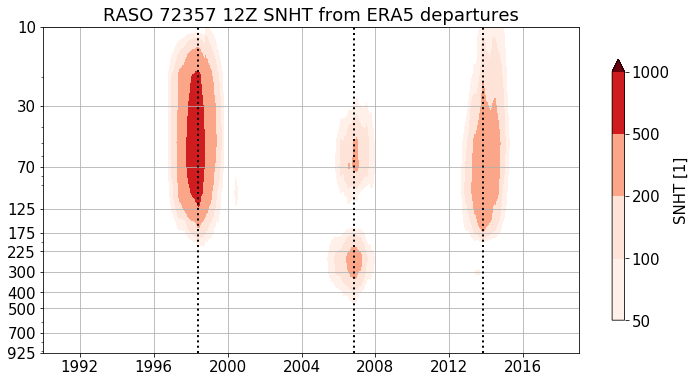

In [38]:
cs = easy_plot(data['hur_obs_minus_an_snht'].sel(hour=12).T, levels=[50,100,200,500,1000], cmap='Reds', extend='max')
ibreaks = raso_adj_cdm_v0.get_breakpoints(data['hur_obs_minus_an_snht_breaks'].sel(hour=12))
for i in ibreaks:
    axvline(x=data['time'].values[i], color='k', ls=':')
print("Breakpoints:", data['time'].values[ibreaks])
grid()
colorbar(cs, label='SNHT [1]', shrink=0.8);
yscale('log')
ylim(100000, 1000)
yticks(ticks=yplevs, labels=ylabels);
title("RASO {} 12Z SNHT from ERA5 departures".format(ident));

## Adjustments

The adjustments need to be applied (added) to the field of relative humdity

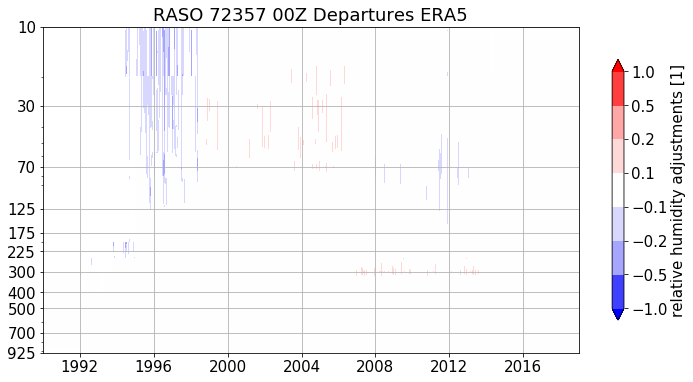

In [39]:
cs = easy_plot(data['hur_q'].sel(hour=0).T, levels=[-1,-0.5,-0.2,-0.1,0.1,0.2,0.5,1],extend='both', cmap='bwr')
grid()
colorbar(cs, label='relative humidity adjustments [1]', shrink=0.8);
yscale('log')
ylim(100000, 1000)
yticks(ticks=yplevs, labels=ylabels);
title("RASO {} 00Z Departures ERA5".format(ident));

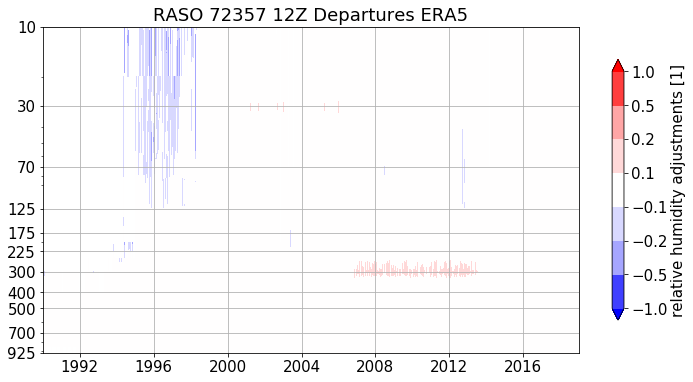

In [40]:
cs = easy_plot(data['hur_q'].sel(hour=12).T, levels=[-1,-0.5,-0.2,-0.1,0.1,0.2,0.5,1],extend='both', cmap='bwr')
grid()
colorbar(cs, label='relative humidity adjustments [1]', shrink=0.8);
yscale('log')
ylim(100000, 1000)
yticks(ticks=yplevs, labels=ylabels);
title("RASO {} 12Z Departures ERA5".format(ident));

## Original vs Adjusted

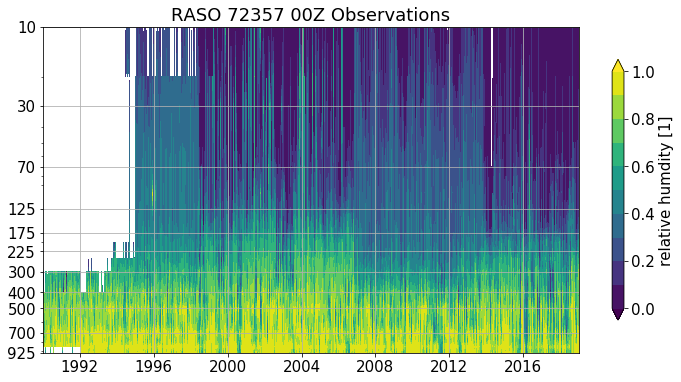

In [41]:
cs = easy_plot((data.hur).sel(hour=0).T,extend='both', levels=np.arange(0,1.1,0.1))
grid()
colorbar(cs, extend='both', label='relative humdity [1]', shrink=0.8);
yscale('log')
ylim(100000, 1000)
yticks(ticks=yplevs, labels=ylabels);
title("RASO {} 00Z Observations".format(ident));

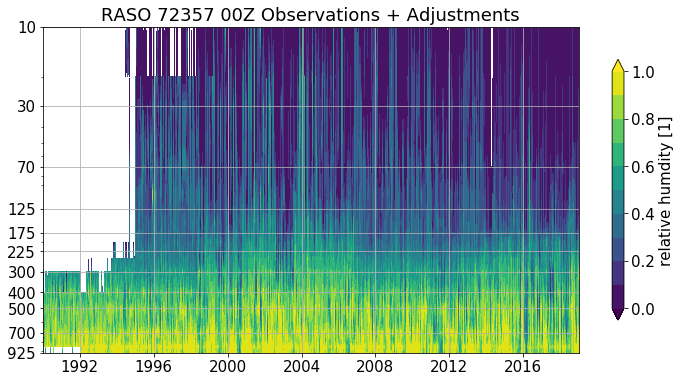

In [42]:
cs = easy_plot((data['hur'] + data['hur_q']).sel(hour=0).T,extend='both', levels=np.arange(0,1.1,0.1))
grid()
colorbar(cs, extend='both', label='relative humdity [1]', shrink=0.8);
yscale('log')
ylim(100000, 1000)
yticks(ticks=yplevs, labels=ylabels);
title("RASO {} 00Z Observations + Adjustments".format(ident));

## Vertical

Comparison of medians from unadjusted observations and adjusted observations as well as ERA5.

In [43]:
import pandas as pd

In [44]:
idata = pd.DataFrame(data['hur'].sel(hour=0).values, index=data['time'].values, columns=data['plev'].values)
idata.columns = (idata.columns/100).astype(int)

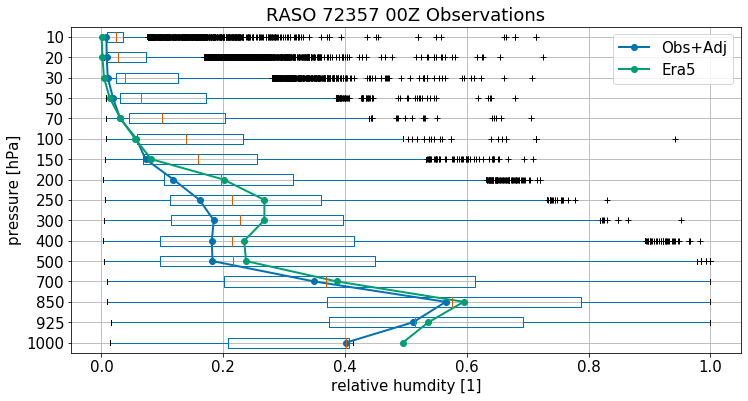

In [45]:
idata = idata.sort_index(axis=1, ascending=False)
ax = idata.boxplot(vert=False, return_type='axes', sym='+')
# median of adjusted obeservations
ax.plot((data['hur'] + data['hur_q']).sel(hour=0).median('time').to_dataframe('adj')['adj'].values,np.arange(16,0,-1), label='Obs+Adj', marker='o')
ax.plot((data['hur'] - data['hur_obs_minus_an']).sel(hour=0).median('time').to_dataframe('era')['era'].values,np.arange(16,0,-1), label='Era5', marker='o')
ylabel('pressure [hPa]')
xlabel('relative humdity [1]');
legend()
title("RASO {} 00Z Observations".format(ident));